In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import poppy

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

from magpyx.fdpr2 import console, tools

wavelength = 633e-9

In [2]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [14]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

# Do the normalization

In [12]:
scoobi.move_psf(-50, 0, client0)

In [11]:
reload(scoobi)
xc, yc = (4400, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [16]:
reload(scoobi)
tbi.set_zwo_exp_time(0.00001, client0)

Set the ZWO exposure time to 3.20e-05s


In [17]:
reload(scoobi)
tbi.set_zwo_emgain(120, client0)

Set the ZWO gain setting to 120.0


In [28]:
reload(scoobi)
tbi.set_fib_atten(13, client)

Set the fiber attenuation to 13.0


In [26]:
scoobi.move_psf(-8, 0, client0)

In [24]:
scoobi.move_psf(0, 10, client0)

65532


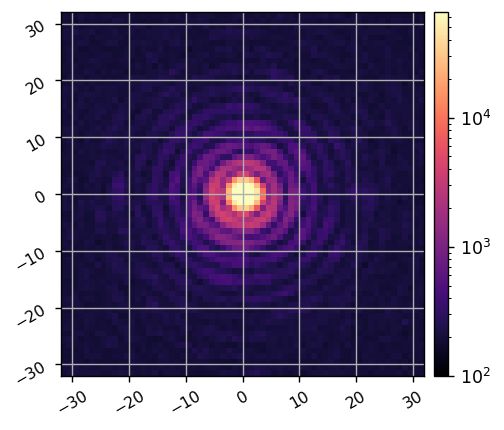

In [27]:
tbi.return_ni = False
psf = tbi.snap()

print(xp.max(psf))
imshow1(psf, lognorm=True, vmin=1e2, pxscl=1, grid=True, npix=64)

In [29]:
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:536: RuntimeWarning: divide by zero encountered in log
  amp_lnrms = np.std(np.log(amp_norm)[amp_mask])#rms(np.log(amp_norm), pupil)
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:124: RuntimeWarning: divide by zero encountered in log
  log_amp = np.log(amp)
INFO:fdpr2:Estimated phase RMS: 0.194 (rad)
INFO:fdpr2:Estimated amplitude RMS: 8.19 (%)
INFO:fdpr2:Estimated Strehl: 0.96 (0.96 phase-only and 0.99 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


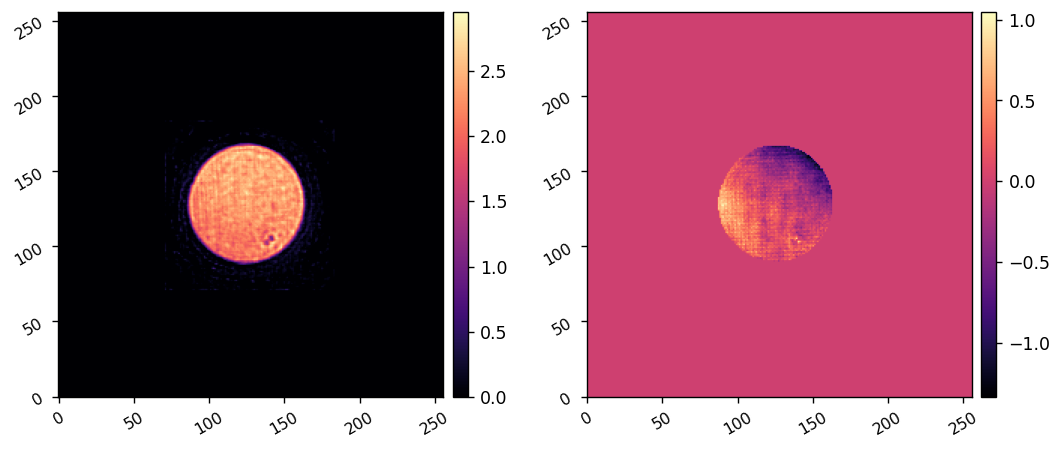

In [30]:
imshow2(fitdict['amp_est'], fitdict['phase_est'])

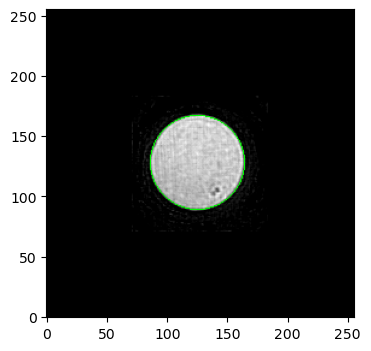

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Load picture and detect edges
# image = img_as_ubyte(data.coins()[160:230, 70:270])
image = img_as_ubyte(fitdict['amp_est']/np.max(fitdict['amp_est']))
# image = img_as_ubyte(np.abs(fitdict['phase_est'])/np.max(np.abs(fitdict['phase_est'])))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=100)

# Detect two radii
hough_radii = np.arange(35, 45, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

In [53]:
radii[0]

39

In [47]:
np.arange(30, 60, 9)

array([30, 39, 48, 57])

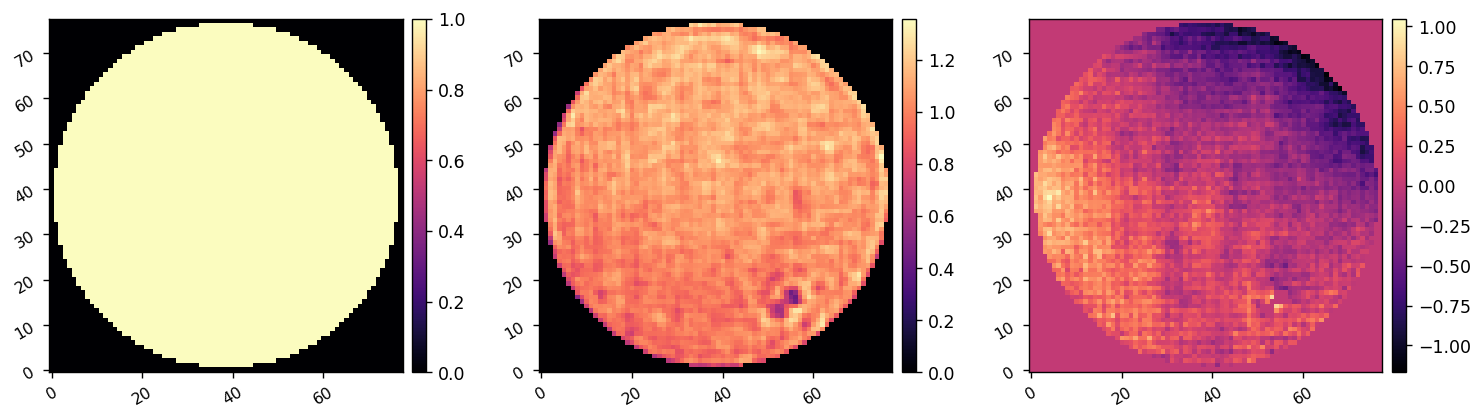

In [76]:
amp_est = fitdict['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est = fitdict['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
Nfit = amp_est.shape[0]
y,x = (np.indices((Nfit, Nfit)) - Nfit/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(radii[0]-1)

amp_est *= fit_mask
phs_est *= fit_mask
imshow3(fit_mask, amp_est, phs_est)



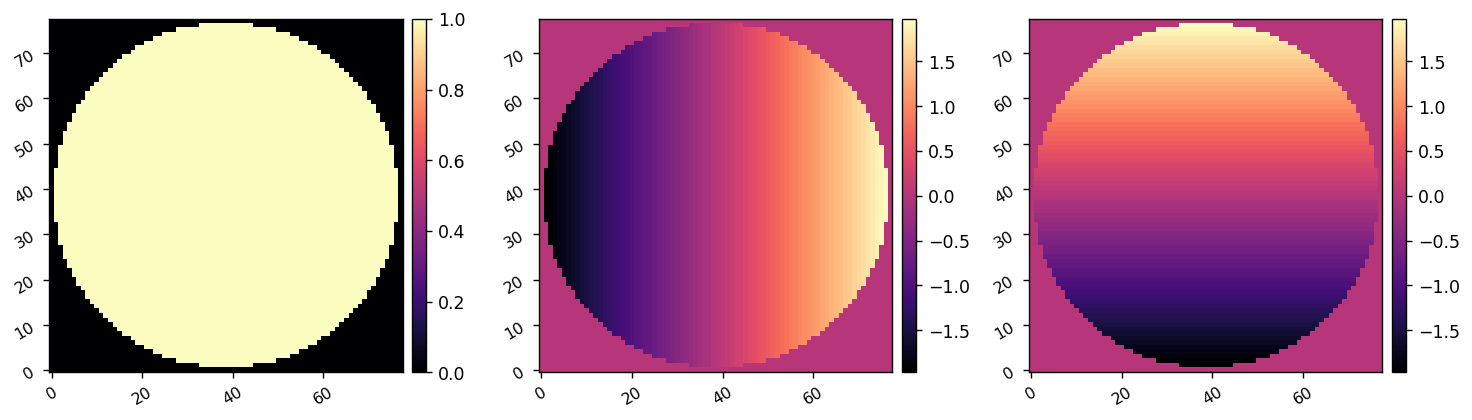

[-0.0087171  -0.22240362 -0.19993687]


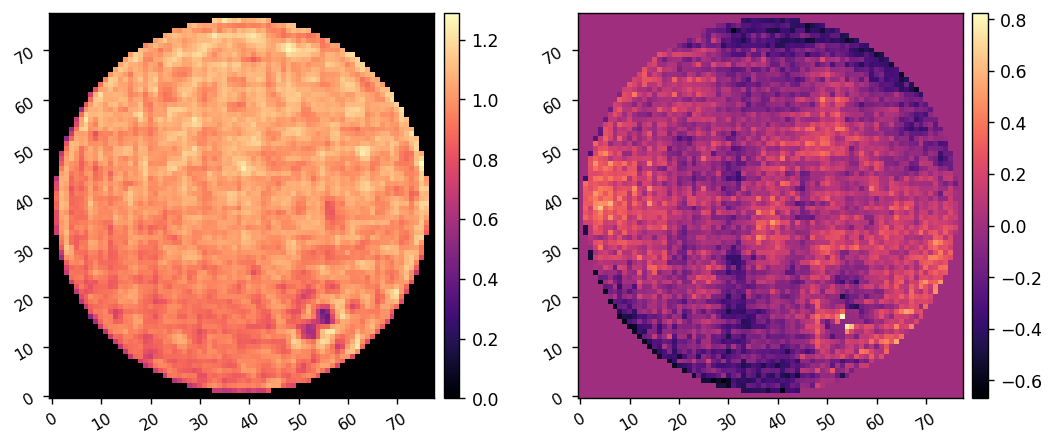

In [79]:
z_modes = poppy.zernike.arbitrary_basis(fit_mask, nterms=3, outside=0)
ptt_modes = z_modes[:3]
imshow3(ptt_modes[0], ptt_modes[1], ptt_modes[2])

# ptt_coeff = scoobpsf.utils.lstsq(ptt_modes,xp.array(phs_est))
# ptt = ensure_np_array(ptt_modes.reshape(3,-1).T.dot(ptt_coeff).reshape(Nfit,Nfit))
# phs_est_minus_ptt = phs_est - ptt

z_coeff = scoobpsf.utils.lstsq(z_modes,xp.array(phs_est))
print(z_coeff)
ptt_coeff = z_coeff[:3]
ptt = ensure_np_array(ptt_modes.reshape(3,-1).T.dot(ptt_coeff).reshape(Nfit,Nfit))
phs_est_minus_ptt = phs_est - ptt

amp_est /= np.mean(amp_est[fit_mask])

imshow2(amp_est/np.mean(amp_est[fit_mask]), phs_est_minus_ptt)




83


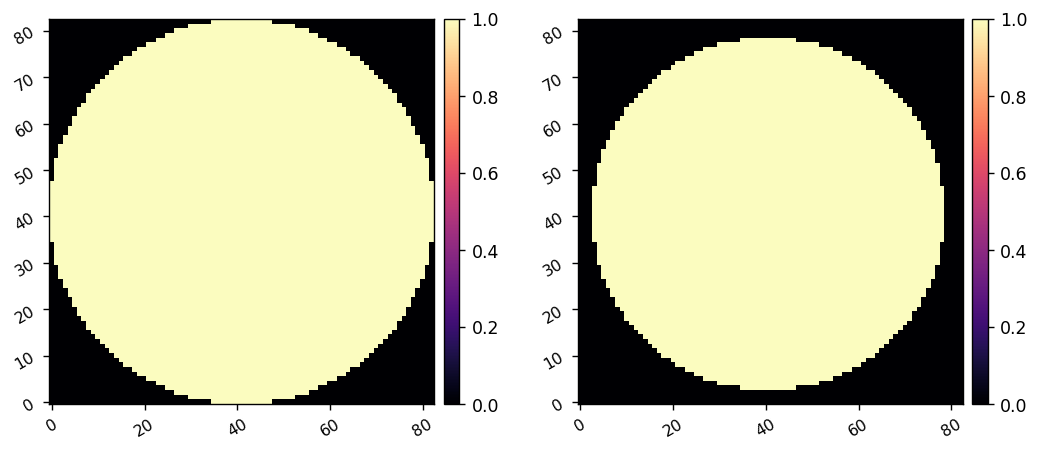

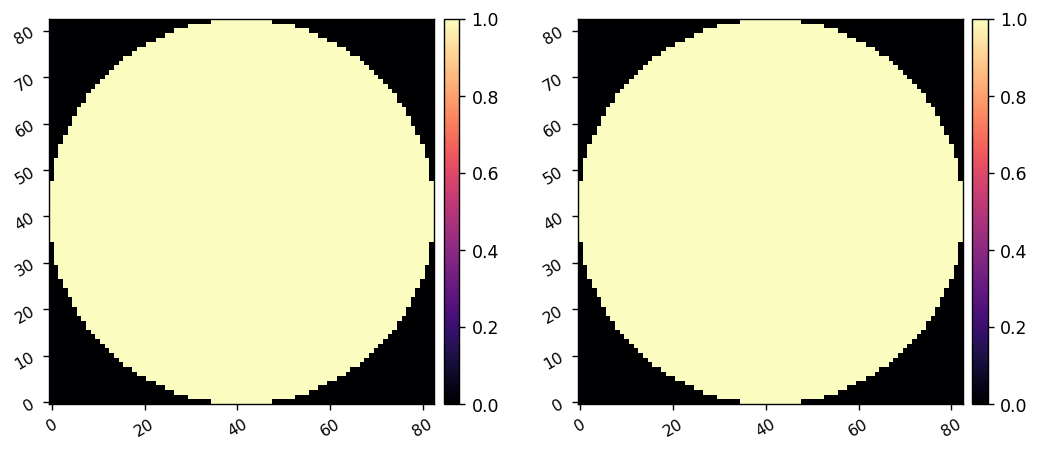

In [70]:
Nfull = int(np.round(Nfit * 9.1/8.6))
print(Nfull)
y,x = xp.indices((Nfull,Nfull)) - Nfull//2
r = xp.sqrt(x**2 + y**2)
full_mask = r<Nfull/2

sub_mask = xp.array(amp_est>0.3)
sub_mask = scoobpsf.utils.pad_or_crop(sub_mask, Nfull)
imshow2(full_mask, sub_mask)

full_amp_est = full_mask
full_amp_est[sub_mask] = scoobpsf.utils.pad_or_crop(xp.array(amp_est), Nfull)[sub_mask]
full_phs_est = full_mask
full_phs_est[sub_mask] = scoobpsf.utils.pad_or_crop(xp.array(phs_est_minus_ptt), Nfull)[sub_mask]
imshow2(full_amp_est, full_phs_est)

946
(945, 945)


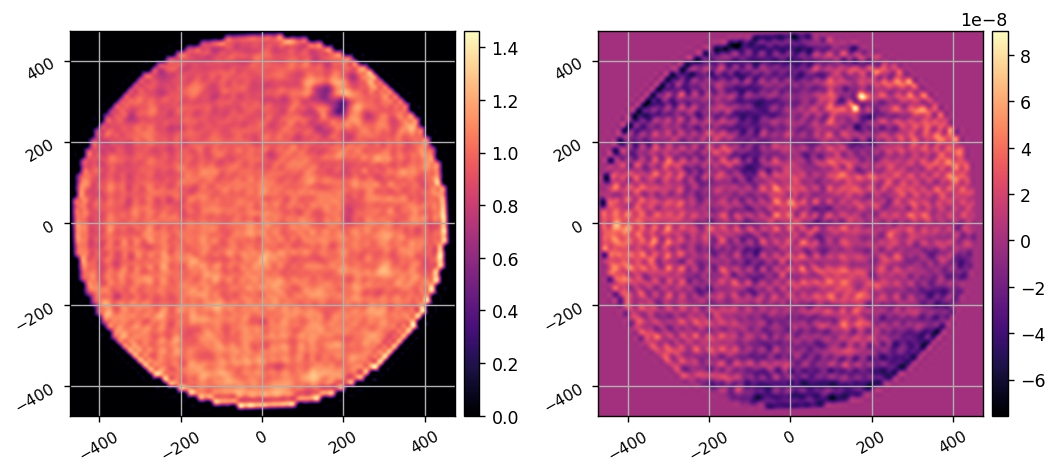

In [82]:
npix = 1000
nlyot = int(np.ceil(8.6/9.1 * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)
# iamp_est = scoobpsf.utils.interp_arr(xp.array(amp_est), 1/Nfit, 1/npix, order=5)
# iphs_est = scoobpsf.utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/npix, order=5)

# iamp_est = scoobpsf.utils.interp_arr(xp.array(full_amp_est), 1/Nfull, 1/npix, order=5)
# iphs_est = scoobpsf.utils.interp_arr(xp.array(full_phs_est), 1/Nfull, 1/npix, order=5)

iamp_est = scoobpsf.utils.interp_arr(xp.array(amp_est), 1/Nfit, 1/nlyot, order=5)
iphs_est = scoobpsf.utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/nlyot, order=5)
print(iamp_est.shape)

iamp_est = scoobpsf.utils.rotate_arr(iamp_est, 2, reshape=False, order=5)
iphs_est = scoobpsf.utils.rotate_arr(iphs_est, 2, reshape=False, order=5)

iamp_est = xp.flipud(iamp_est)
iphs_est = xp.flipud(iphs_est)

iamp_est[iamp_est<0] = 0
iopd_est = iphs_est * wavelength / (2*np.pi)

if iamp_est.shape[0] != npix:
    iamp_est = scoobpsf.utils.pad_or_crop(iamp_est, nlyot)
    iopd_est = scoobpsf.utils.pad_or_crop(iopd_est, nlyot)

imshow2(iamp_est, iopd_est, pxscl=1, grid=True)


In [143]:
iamp_est.shape

(1000, 1000)

In [83]:
scoobpsf.utils.save_fits('data/pr_est_amp.fits', iamp_est)
scoobpsf.utils.save_fits('data/pr_est_opd.fits', iopd_est)

Saved data to:  data/pr_est_amp.fits
Saved data to:  data/pr_est_opd.fits
